In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from statistics import median

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [2]:
RESCALE = 10000000
KERNEL = 1
FEATURES = 8
BATCH = 10
EPOCH = 40

In [3]:
#function that loads files for the network
def load_files(filenames, category, num_categories):
    #the 1D convnet needs to specify the third axis of the tensor
    glitches = np.zeros((len(filenames), 100, 1))
    category_matrix = np.zeros((len(filenames), num_categories))
    for i in range(len(filenames)):
        current_data = np.loadtxt(filenames[i])
        glitches[i,:,0] = current_data[1]
        #I save 1s on the axis for that respective category
        category_matrix[i,category] = 1
    return glitches, category_matrix

In [4]:
glitches, cat_glitches = load_files(glob("Train Data/glitch/*.txt"), 0, 2)
no_glitches, cat_no_glitches = load_files(glob("Train Data/no_glitch/*.txt"), 1, 2)

#long_glitches, cat_long_glitches = load_files(glob("Train Data/long_glitch/*.txt"), 2, 3)

In [5]:
x = np.concatenate((glitches, no_glitches))
                    #long_glitches))
y = np.concatenate((cat_glitches, cat_no_glitches))
                    #cat_long_glitches))

In [6]:
# traslate the data on on each median
for i in range(len(x)):
    x[i,:,0] = x[i,:,0] - median(x[i,:,0])

In [7]:
# rescale the data: the network gives problems with too small data. 
# The rescaling is arbitrary, but it works.
for j in range(len(x)):
    for i in range(100):
        x[j,i,0] = x[j,i,0] * RESCALE

In [8]:
# I run a permutation, in order to mix up the data
perm = np.random.permutation(x.shape[0])
# I want to have the same permutation on both x and y 
np.take(x, perm, axis=0, out=x)
np.take(y, perm, axis=0, out=y)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [9]:
maximus = 1964
x_train = x[:maximus,:,:]
y_train = y[:maximus,:]

x_test = x[-1,:,:]
y_test = y[-1,:]

In [10]:
print("Forma dei dati: ", x_train.shape)

Forma dei dati:  (1964, 100, 1)


In [11]:
time_length = len(x_train[0,:,0])

In [12]:
# My model
network = models.Sequential()

network.add(layers.Conv1D(FEATURES,
                          kernel_size=KERNEL, 
                         activation='relu', 
                          input_shape=(time_length,1)))

network.add(layers.GlobalMaxPooling1D())

network.add(layers.Dense(64, activation='softmax'))
network.add(layers.Dropout(0.6))
network.add(layers.Dense(64, activation='softmax'))
network.add(layers.Dense(1, activation='sigmoid'))

In [13]:
print(network.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 8)            16        
_________________________________________________________________
global_max_pooling1d (Global (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,817
Trainable params: 4,817
Non-trainable params: 0
______________________________________________________

In [14]:
#rmsprop = optimizers.RMSprop(lr=0.001, rho=0.5, epsilon=None, decay=0.1)
network.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
history = network.fit(x_train, y_train[:,0], epochs=EPOCH, batch_size=BATCH, shuffle=False
                      ,validation_split=0.2)
                      #,steps_per_epoch=None)
                      #,validation_data=(x_validation, y_validation[:,0]))

Train on 1571 samples, validate on 393 samples
Epoch 1/40
1571/1571 [==============================] - 1s 486us/sample - loss: 0.6895 - accuracy: 0.6378 - val_loss: 0.6839 - val_accuracy: 0.5445
Epoch 2/40
1571/1571 [==============================] - 0s 241us/sample - loss: 0.6788 - accuracy: 0.6785 - val_loss: 0.6694 - val_accuracy: 0.5445
Epoch 3/40
1571/1571 [==============================] - 0s 230us/sample - loss: 0.6621 - accuracy: 0.7034 - val_loss: 0.6467 - val_accuracy: 0.8550
Epoch 4/40
1571/1571 [==============================] - 0s 221us/sample - loss: 0.6368 - accuracy: 0.7148 - val_loss: 0.6146 - val_accuracy: 0.9389
Epoch 5/40
1571/1571 [==============================] - 0s 297us/sample - loss: 0.6118 - accuracy: 0.7015 - val_loss: 0.5776 - val_accuracy: 0.9593
Epoch 6/40
1571/1571 [==============================] - 0s 204us/sample - loss: 0.5788 - accuracy: 0.7148 - val_loss: 0.5358 - val_accuracy: 0.9618
Epoch 7/40
1571/1571 [==============================] - 0s 206us/

In [16]:
history_dic = history.history
loss_values = history_dic['loss']
val_loss_values = history_dic['val_loss']
acc = history_dic['accuracy']
val_acc = history_dic['val_accuracy']

In [17]:
epochs = range(1, len(acc) + 1)

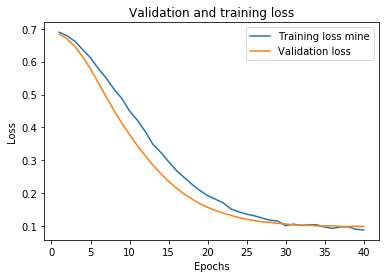

In [18]:
plt.plot(epochs, loss_values, label='Training loss mine')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Validation and training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/loss.png', dpi=600)
plt.show()

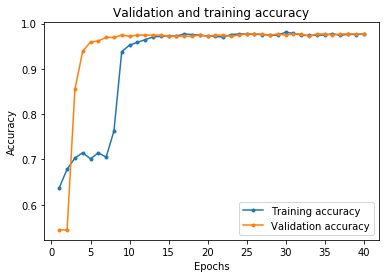

In [19]:

plt.plot(epochs, acc, label='Training accuracy', marker='.')
plt.plot(epochs, val_acc, label='Validation accuracy', marker='.')
plt.title('Validation and training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0, 1)
plt.legend()
plt.savefig('plots/accuracy.png', dpi=600)
plt.show()

In [20]:
network.save('networks/glitch_detector.h5')

In [21]:
x_test = np.reshape(x_test, (1,100,1))

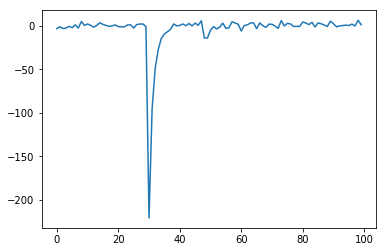

In [22]:
plt.plot(x_test[0,:,0])
plt.title("The probability for the timeseries to be glitch is "+str(int((np.reshape(network.predict(x_test), ()))*10000)/100)+"%\n")
plt.xlabel("")
plt.ylabel("Voltages [10⁻⁷V]")
plt.savefig("plots/test_example.png", dpi=600)
plt.show()bo

In [23]:
print("La probabilità che il dato fornito presenti un glitch è:", int((np.reshape(network.predict(x_test), ()))*10000)/100, "%" )

La probabilità che il dato fornito presenti un glitch è: 97.32 %


In [24]:
if( int((np.reshape(network.predict(x_test), ()))*10000)/100 < 50.):
    print("NO GLITCH")
else:
    print('GLITCH')

GLITCH


In [25]:
if print(int(y_test[0])) == 1:
    print("It was classified as a glitch.")

1


## Annotazioni

Massimo validation accuracy per ora: ~98%

##### _NOTA_:      
- Ho notato che ci possono esser dei problemi nella validazione: se utilizzo la funzione ```validation_split``` già presente dentro il ```fit```, viene tutto bene. Viceversa, se provo a dividere io i dati (come avevamo fatto all'inizio), sebbene ottenga sempre gli stessi risultati sulla _training accuracy_, ho che la _validation accuracy_ è nulla. Questo vale sia che io faccia lo _shuffle_ autonomamente, sia che io ponga ```shuffle=True``` dentro la funzione di ```fit```.

- Ho fatto un piccolo script per scegliere quale sia la migliore grandezza del kernel.

    Risulato: ```kernel_size=1``` da una _validation accuracy_ del 96%.

- Ho eseguito la stessa cosa per la quantità di features. Ho ottenuto che con ```features = 8``` mi viene una _validation accuracy_ del 98%.

- La tecnica che ho usato è stato prendere l'ultimo valore della _validation accuracy_ in ogni tentativo, e non per forza il valore migliore in ogni _run_ (quando raggiunge il massimo tende a oscillare leggermente).

- Facendo un test analogo sulla ```batch_size``` ho notato che queste non modificano l'apprendimento. L'unico significativo risultato è che, come ci si potrebbe aspettare, con delle ```batch_size``` piccole ogni epoca ci mette più; e, viceversa, con delle ```batch_size``` troppo grandi servono molto più epoche per raggiungere un'accuratezza sensata.

------------ 

---------


## Considerazioni generali

- Ho scoperto che il ```tensorflow``` lavora in ```float```; in alcune istanze, come con i miei dati (che sono molti piccoli), ci possono essere dei problemi. Ho deciso dunque di moltiplicare i dati per un fattore di scalare ```RESCALE = 10'000'000```. Con questo accorgimento la rete funziona senza problemi.


- Nella tesi conviene scrivere il tentativo fatto con i "dati farlocchi", e in particolare come sono arrivato alla soluzione del problema.

- Il lavoro potrebbe essere importante in vista del progetto **LiteBIRD** dell'agenzia spaziale giapponese.

- Se provo a fare una classificazione con anche i _long glitches_, viene una buona _accuracy_, ma non riesco a trovare quelli _long_. Penso che il motivo sia legato alla scarsità di dati a disposizione.

- Mi è capitato di beccare un dato classificato male da me ma bene dal network.

- Probabilmente, per ottenere delle accuracy più elevate servirebbe semplicemente un numero maggiore di dati – magari il doppio o il triplo. Forse si potrebbero provare delle tecniche di _data augmentation_, ma non penso che possano fare molto.

---------
-----

- Ho provato l'accuratezza del network con dati da un altro giorno (94 al posto che 93), ma stesso rilevatore, e ho ottenuto dei risultati soddisfacienti: su 100 plot che gli ho dato, 98 me li ha classificati correttamente. I due che ha sbagliato sono oggettivamente dei casi un po' "particolari".

    Piccola **nota**: in alcuni casi, si deve riscalare con un "–" a causa del fatto che le differenza di potenziale sono positive o negative in maniera arbitraria.

- Ho provato anche con un altro detector sul file del giorno ```100```, e funziona perfettamente (mi da 99%, ma sono sicuro di averne classificato male io uno).

- Ho provato a vedere l'effiacia del network con diversi tipi di dati e rimanda sempre risultati soddisfacienti (risultato peggiore ```~97%```). Unico problemi che ho riscontrato: nei casi in cui i valori variano bruscamente, ma in evidente assenza di glitch, il network sbaglia a classificare.

    Un esempio di questo può essere dato dalla seguente immagine.

    ![Example: bad](plots/Bad_data.png)


## Cose da fare

- Provo a utilizzare rms per fare paragone in classificazione. FATTO. 

    RISULTATO: non soddisfaciente. Non sono riuscito, in maniera semplice, a ottenere un modo per classificare i dati.
        
    **Proposte**: forse si potrebbe migliorare questa tecnica andando a dividere i 100 dati in intervalli (per esempio 5), calcolare l'```rms``` per i singoli intervalli e poi prendere il max tra questi. Magari con questo criterio si riesce a ottenere un'_accuracy_ migliore.
    
    **RISULTATO_1**: sono riucito a ottenere un'_accuracy_ del 97% sui dati di testing con la mia tecnica del "dividere ogni _timeseries_ in sottointervalli".
    
    Nella tesi mettere una sequenza glitch con rms basso e una non-glitch con rms alto.
    
    Si potrebbe spiegare questo metodo anche prima delle reti neurali.
    
    Posso normalizzare sulla differenza tra il terzo e il primo quartile.
    
    **RISULTATO_2**: la tenica con i quartili non mi è riuscita: oltre a uccidere molto l'```rms``` di quelli senza glitch, uccideva anche alcuni di quelli coi glitch, rendendo tutto completamente inutile – anche peggio che non fare niente (~70% accuracy). 
    
    **Conclusioni ```rms```**: la divisione di ogni _timeseries_ in 7 blocchi è la tecnica che per ora mi ha dato il miglior risultato. 
   

- Potrei dividere i dati di test in due gruppi: uno in cui sono certo della classificazione, e un altro con tutti i casi dubbi. Provo quindi a rifare il training sul primo set. Esegueo poi questa rete su dei dati di cui non sono sicuro.    NON FATTO.

    **Proposta**: con questa tecnica posso aggiustare al problema che ho riscontrato durante il test (vedi grafici sopra).

- Devo fare il paragone con altri rilevatori. Per portarlo fare, devo riaddestrare la rete in Kelvin – devo quindi andare a modificare lo script che mi prepara i dati da classificare.

    A questo punto il mio codice dovrebbe essere pronto a fare qualsiasi cosa.  FATTO.
    
    **Nota**: non ho dovuto riaddestrare la rete in Kelvin. Va bene anche così com'è addestrata sugli altri rilevatori (ho provato solo su pochi altri, dato che è molto lungo mettersi a classificare 100 dati test per volta, ma ritengo che vada bene). _Vedi sopra per commento approfondito_.

-------- 

------ 